# Introduction

So far, our agents have relied on detailed information about how to play the game.  The heuristic really provides a lot of guidance about how to select moves!

In this tutorial, you'll learn how to use **reinforcement learning** to build an intelligent agent without the use of a heuristic.  Instead, we will gradually refine the agent's strategy over time, simply by playing the game and trying to maximize the winning rate.

In this notebook, we won't be able to explore this complex field in detail, but you'll learn about the big picture and explore code that you can use to train your own agent.

# Neural Networks

It's difficult to come up with a perfect heuristic.  Improving the heuristic generally entails playing the game many times, to determine specific cases where the agent could have made better choices.  And, it can prove challenging to interpret what exactly is going wrong, and ultimately to fix old mistakes without accidentally introducing new ones.

Wouldn't it be much easier if we had a more systematic way of improving the agent with gameplay experience?  

In this tutorial, towards this goal, we'll replace the heuristic with a neural network.

The network accepts the current board as input.  And, it outputs a probability for each possible move.

<center>
<img src="https://i.imgur.com/KgAliYQ.png" width=90%><br/>
</center>

Then, the agent selects a move by sampling from these probabilities.  For instance, for the game board in the image above, the agent selects column 4 with 50% probability.

This way, to encode a good gameplay strategy, we need only amend the weights of the network so that _for every possible game board_, it assigns higher probabilities to better moves.

At least in theory, that's our goal.  In practice, we won't actually check if that's the case -- since remember that Connect Four has over 4 trillion possible game boards!

# Setup

How can we approach the task of amending the weights of the network, in practice?  Here's the approach we'll take in this lesson:
- After each move, we give the agent a **reward** that tells it how well it did:
  - **_If_** the agent wins the game in that move, we give it a reward of `+1`.
  - **_Else if_** the agent plays an invalid move (which ends the game), we give it a reward of `-10`.
  - **_Else if_** the opponent wins the game in its next move (i.e., the agent failed to prevent its opponent from winning), we give the agent a reward of `-1`.
  - **_Else_**, the agent gets a reward of `1/42`.
  
  
- At the end of each game, the agent adds up its reward.  We refer to the sum of rewards as the agent's **cumulative reward**.  
  - For instance, if the game lasted 8 moves (each player played four times), and the agent ultimately won, then its cumulative reward is `3*(1/42) + 1`.
  - If the game lasted 11 moves (and the opponent went first, so the agent played five times), and the opponent won in its final move, then the agent's cumulative reward is `4*(1/42) - 1`.
  - If the game ends in a draw, then the agent played exactly 21 moves, and it gets a cumulative reward of `21*(1/42)`.
  - If the game lasted 7 moves and ended with the agent selecting an invalid move, the agent gets a cumulative reward of `3*(1/42) - 10`.
  
Our goal is to find the weights of the neural network that (on average) maximize the agent's cumulative reward.  

This idea of using reward to track the performance of an agent is a core idea in the field of reinforcement learning.  Once we define the problem in this way, we can use any of a variety of reinforcement learning algorithms to produce an agent.

# Reinforcement Learning

There are many different reinforcement learning algorithms, such as DQN, A2C, and PPO, among others.  All of these algorithms use a similar process to produce an agent:

- Initially, the weights are set to random values.


- As the agent plays the game, the algorithm continually tries out new values for the weights, to see how the cumulative reward is affected, on average.  Over time, after playing many games, we get a good idea of how the weights affect cumulative reward, and the algorithm settles towards weights that performed better.  
    - _Of course, we have glossed over the details here, and there's a lot of complexity involved in this process.  For now, we focus on the big picture!_
    
    
- This way, we'll end up with an agent that tries to win the game (so it gets the final reward of `+1`, and avoids the `-1` and `-10`) and tries to make the game last as long as possible (so that it collects the `1/42` bonus as many times as it can).
    - _You might argue that it doesn't really make sense to want the game to last as long as possible -- this might result in a very inefficient agent that doesn't play obvious winning moves early in gameplay.  And, your intuition would be correct -- this will make the agent take longer to play a winning move!  The reason we include the `1/42` bonus is to help the algorithms we'll use to converge better.  Further discussion is outside of the scope of this course, but you can learn more by reading about the "temporal credit assignment problem" and "reward shaping"._
    
In the next section, we'll use the [**Proximal Policy Optimization (PPO)**](https://openai.com/blog/openai-baselines-ppo/) algorithm to create an agent.

# Code

There are a lot of great implementations of reinforcement learning algorithms online.  In this course, we'll use [Stable Baselines](https://github.com/hill-a/stable-baselines).

Currently, Stable Baselines is not yet compatible with TensorFlow 2.0.  So, we begin by downgrading to TensorFlow 1.0.

In [5]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Check version of tensorflow
!pip install 'tensorflow==1.15.0'
import tensorflow as tf
tf.__version__

To learn more about how to define environments, check out the documentation [here](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html).

In [ ]:
!pip install kaggle_environments

In [8]:
from kaggle_environments import make, evaluate, agent
from gym import spaces

class ConnectFourGym:
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(self.rows,self.columns,1), dtype=np.int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1), reward, done, _

Loading environment football failed: No module named 'gfootball'


In this notebook, we'll train an agent to beat the **HEURISTIC** agent.  We specify this opponent in the `agent2` argument below.

In [70]:
#@title Heuristic Agent
def heuristic(obs, config):

    ################################
    # Imports and helper functions #
    ################################
    
    import numpy as np
    import random
    import time
    
    # How deep to make the game tree: higher values take longer to run!
    # lookahead depth:
    N_STEPS = 2#@param {type:"integer"}

    # Gets board at next step if agent drops piece in selected column
    def drop_piece(grid, col, mark, config):
        next_grid = grid.copy()
        for row in range(config.rows-1, -1, -1):
            if next_grid[row][col] == 0:
                break
        next_grid[row][col] = mark
        return next_grid

    # Helper function for get_heuristic: checks if window satisfies heuristic conditions
    def check_window(window, num_discs, piece, config):
        return (window.count(piece) == num_discs and window.count(0) == config.inarow-num_discs)

    # Helper function for get_heuristic: counts number of windows satisfying specified heuristic conditions
    def count_windows(grid, num_discs, piece, config):
        num_windows = 0
        # horizontal
        for row in range(config.rows):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[row, col:col+config.inarow])
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        # vertical
        for row in range(config.rows-(config.inarow-1)):
            for col in range(config.columns):
                window = list(grid[row:row+config.inarow, col])
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        # positive diagonal
        for row in range(config.rows-(config.inarow-1)):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        # negative diagonal
        for row in range(config.inarow-1, config.rows):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        return num_windows
    
    # Helper function for minimax: calculates value of heuristic for grid
    A = 2
    B = 20
    C = -1
    D = -10
    def get_heuristic(grid, mark, config):
        num_threes = count_windows(grid, 3, mark, config) #A
        num_fours = count_windows(grid, 4, mark, config)  #B
        num_threes_opp = count_windows(grid, 3, mark%2+1, config) #C
        num_fours_opp = count_windows(grid, 4, mark%2+1, config)  #D
        score = A*num_threes + C*num_threes_opp + D*num_fours_opp + B*num_fours
        return score

    # Helper function for minimax: checks if agent or opponent has four in a row in the window
    def is_terminal_window(window, config):
        return window.count(1) == config.inarow or window.count(2) == config.inarow

    # Helper function for minimax: checks if game has ended
    def is_terminal_node(grid, config):
        # Check for draw 
        if list(grid[0, :]).count(0) == 0:
            return True
        # Check for win: horizontal, vertical, or diagonal
        # horizontal 
        for row in range(config.rows):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[row, col:col+config.inarow])
                if is_terminal_window(window, config):
                    return True
        # vertical
        for row in range(config.rows-(config.inarow-1)):
            for col in range(config.columns):
                window = list(grid[row:row+config.inarow, col])
                if is_terminal_window(window, config):
                    return True
        # positive diagonal
        for row in range(config.rows-(config.inarow-1)):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
                if is_terminal_window(window, config):
                    return True
        # negative diagonal
        for row in range(config.inarow-1, config.rows):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
                if is_terminal_window(window, config):
                    return True
        return False

    # Minimax implementation
    def minimax(node, depth, maximizingPlayer, mark, config):
        is_terminal = is_terminal_node(node, config)
        valid_moves = [c for c in range(config.columns) if node[0][c] == 0]
        if depth == 0 or is_terminal:
            return get_heuristic(node, mark, config)
        if maximizingPlayer:
            value = -np.Inf
            for col in valid_moves:
                child = drop_piece(node, col, mark, config)
                value = max(value, minimax(child, depth-1, False, mark, config))
            return value
        else:
            value = np.Inf
            for col in valid_moves:
                child = drop_piece(node, col, mark%2+1, config)
                value = min(value, minimax(child, depth-1, True, mark, config))
            return value
        
    # Uses minimax to calculate value of dropping piece in selected column
    def score_move(grid, col, mark, config, nsteps):
        next_grid = drop_piece(grid, col, mark, config)
        score = minimax(next_grid, nsteps-1, False, mark, config)
        return score
    
    #########################
    # Agent makes selection #
    #########################
    
    # Get list of valid moves
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    
    # Convert the board to a 2D grid
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    
    # Use the heuristic to assign a score to each possible board in the next step
    scores = dict(zip(valid_moves, [score_move(grid, col, obs.mark, config, N_STEPS) for col in valid_moves]))
    
    # Get a list of columns (moves) that maximize the heuristic
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    
    # Select at random from the maximizing columns
    return random.choice(max_cols)

In [79]:
# @title Experimental Pruning Agent "pruneX"
def pruneX(obs, config):
    #config is dict: {'rows': 6, 'columns': 7, 'inarow': 4}
    # obs.board is last move of opponent, obs.mark is current player
    # return column that max's next grid's score

    ################################
    # Imports and helper functions #
    ################################

    import numpy as np
    import random
    import time

    ########################### Regular pruner ################
    # constants (given by game)
    ROWS = 6
    COLUMNS = 7
    CNCTX = 4
    ## coefficients (weights on variable future outcomes)
    A = 10       #2 threes
    B = 1000     #10 fours
    C = -1      #-1 opp-threes
    D = -100     #-10 opp-fours   

        # lookahead depth:
    N_STEPS = 4#@ param {type:"integer"}

    # Gets board at next step if agent drops piece in selected column
    def drop_piece(grid, col, mark):
        next_grid = grid.copy()
        for row in range(ROWS-1, -1, -1):       ###row in range(0,ROWS)??
            if next_grid[row][col] == 0:
                break
        next_grid[row][col] = mark
        return next_grid

    # Helper function for get_heuristic: checks if window satisfies heuristic conditions
    def check_window(window, num_discs, piece):
        return (window.count(piece) == num_discs and window.count(0) == CNCTX-num_discs)

    # Helper function for get_heuristic: counts number of windows satisfying specified heuristic conditions
    def count_windows(grid, num_discs, piece):
        num_windows = 0
        # horizontal
        for row in range(ROWS):
            for col in range(COLUMNS-(CNCTX-1)):
                window = list(grid[row, col:col+CNCTX])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        # vertical
        for row in range(ROWS-(CNCTX-1)):
            for col in range(COLUMNS):
                window = list(grid[row:row+CNCTX, col])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        # positive diagonal
        for row in range(ROWS-(CNCTX-1)):
            for col in range(COLUMNS-(CNCTX-1)):
                window = list(grid[range(row, row+CNCTX), range(col, col+CNCTX)])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        # negative diagonal
        for row in range(CNCTX-1, ROWS):
            for col in range(COLUMNS-(CNCTX-1)):
                window = list(grid[range(row, row-CNCTX, -1), range(col, col+CNCTX)])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        return num_windows

    # Helper function for minimax: calculates value of heuristic for grid
    def get_score(grid, mark):
        num_threes = count_windows(grid, 3, mark) #A
        num_fours = count_windows(grid, 4, mark)  #B
        num_threes_opp = count_windows(grid, 3, mark%2+1) #C
        num_fours_opp = count_windows(grid, 4, mark%2+1)  #D

        score = A*num_threes + B*num_fours + C*num_threes_opp + D*num_fours_opp
        is_terminal = (not num_fours == 0) or (not num_fours_opp == 0) or (list(grid[0, :]).count(0) == 0)
        return score, is_terminal

    # Minimax implementation was here:
    def alphabeta(node, depth, alpha, beta, maximizingPlayer, mark):

        node_score, is_terminal = get_score(node, mark)
        if depth == 0 or is_terminal:
            return node_score
        
        valid_moves = [c for c in range(COLUMNS) if node[0][c] == 0]
        
        if maximizingPlayer:
            value = -np.Inf
            for col in valid_moves:
                child = drop_piece(node, col, mark)
                value = max(value, alphabeta(child, depth-1, alpha, beta, False, mark))
                alpha = max(alpha, value)
                if alpha >= beta or (value >= (B + 2*C)):
                    break
            return value
        
        else: #minimizing player
            value = np.Inf
            for col in valid_moves:
                child = drop_piece(node, col, mark%2+1)
                value = min(value, alphabeta(child, depth-1, alpha, beta, True, mark))
                beta = min(beta, value)
                if alpha >= beta or (value <= (D + 2*A)):
                    break
            return value

    # Uses minimax to calculate value of dropping piece in selected column
    def score_move(grid, col, mark, nsteps):
        next_grid = drop_piece(grid, col, mark)
        score = alphabeta(next_grid, nsteps-1, -np.Inf, np.Inf, False, mark)     
        return score

    #########################
    # Agent makes selection #
    #########################

    # Get list of valid moves
    valid_moves = [c for c in range(COLUMNS) if obs.board[c] == 0]

    # Convert the board to a 2D grid
    grid = np.asarray(obs.board).reshape(ROWS, COLUMNS)

    #Use the heuristic to assign a score to each possible board in the next step
    scores = dict(zip(valid_moves, [score_move(grid, col, mark, N_STEPS) for col in valid_moves]))
    returning_scores = []
    for col in valid_moves:
        col_score = score_move(grid, col, mark, N_STEPS)
        returning_scores.append(col_score)
        if col_score >= A:# or col_score <= D:
            break
    #scores = dict(zip(valid_moves, returning_scores))   

    # Get a list of columns (moves) that maximize the heuristic
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    max_choice = random.choice(max_cols)

    return max_choice

In [137]:
#@title Current Pruning Agent "pruner" >>> my_agent
def pruner(obs, config):
    #config is dict: {'rows': 6, 'columns': 7, 'inarow': 4}
    # obs.board is last move of opponent, obs.mark is current player
    # return column that max's next grid's score

    ################################
    # Imports and helper functions #
    ################################

    import numpy as np
    import random

    # constants
    ROWS = config.rows
    COLUMNS = config.columns
    CNCTX = config.inarow
    A = 10       #2 threes
    B = 1000     #10 fours
    C = -1      #-1 opp-threes
    D = -100    #-10opp-fours   

    # lookahead depth:
    N_STEPS =   4#@param {type: "number"}

    # Gets board at next step if agent drops piece in selected column
    def drop_piece(grid, col, mark):
        next_grid = grid.copy()
        for row in range(ROWS-1, -1, -1):       ###row in range(0,ROWS)??
            if next_grid[row][col] == 0:
                break
        next_grid[row][col] = mark
        return next_grid

    # Helper function for get_heuristic: checks if window satisfies heuristic conditions
    def check_window(window, num_discs, piece):
        return (window.count(piece) == num_discs and window.count(0) == CNCTX-num_discs)

    # Helper function for get_heuristic: counts number of windows satisfying specified heuristic conditions
    def count_windows(grid, num_discs, piece):
        num_windows = 0
        # horizontal
        for row in range(ROWS):
            for col in range(COLUMNS-(CNCTX-1)):
                window = list(grid[row, col:col+CNCTX])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        # vertical
        for row in range(ROWS-(CNCTX-1)):
            for col in range(COLUMNS):
                window = list(grid[row:row+CNCTX, col])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        # positive diagonal
        for row in range(ROWS-(CNCTX-1)):
            for col in range(COLUMNS-(CNCTX-1)):
                window = list(grid[range(row, row+CNCTX), range(col, col+CNCTX)])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        # negative diagonal
        for row in range(CNCTX-1, ROWS):
            for col in range(COLUMNS-(CNCTX-1)):
                window = list(grid[range(row, row-CNCTX, -1), range(col, col+CNCTX)])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        return num_windows

    # Helper function for minimax: calculates value of heuristic for grid
    def get_score(grid, mark):

        num_threes = count_windows(grid, 3, mark) #A
        num_fours = count_windows(grid, 4, mark)  #B
        num_threes_opp = count_windows(grid, 3, mark%2+1) #C
        num_fours_opp = count_windows(grid, 4, mark%2+1)  #D

        score = A*num_threes + B*num_fours + C*num_threes_opp + D*num_fours_opp
        is_terminal = (not num_fours == 0) or (not num_fours_opp == 0) or (list(grid[0, :]).count(0) == 0)
        return score, is_terminal

    # Alpha Beta Pruning of MiniMax algorithm:
    def alphabeta(node, depth, alpha, beta, maximizingPlayer, mark):
        node_score, is_terminal = get_score(node, mark)
        if depth == 0 or is_terminal:
            return node_score
 
        valid_moves = [c for c in range(COLUMNS) if node[0][c] == 0]
        if maximizingPlayer:
            value = -np.Inf
            for col in valid_moves:
                child = drop_piece(node, col, mark)
                value = max(value, alphabeta(child, depth-1, alpha, beta, False, mark))
                alpha = max(alpha, value)
                if alpha >= beta or value >= 900:
                    break
            return value
        
        else: #minimizing player
            value = np.Inf
            for col in valid_moves:
                child = drop_piece(node, col, mark%2+1)
                value = min(value, alphabeta(child, depth-1, alpha, beta, True, mark))
                beta = min(beta, value)
                if alpha >= beta or value <= -70:
                    break
            return value

    # Uses minimax to calculate value of dropping piece in selected column
    def score_move(grid, col, mark, nsteps):
        next_grid = drop_piece(grid, col, mark)
        score = alphabeta(next_grid, nsteps-1, -np.Inf, np.Inf, False, mark) 
        return score

    #########################
    # Agent makes selection #
    #########################

    # Get list of valid moves
    valid_moves = [c for c in range(COLUMNS) if obs.board[c] == 0]

    # Convert the board to a 2D grid
    ########## ENTER OBS:
    grid = np.asarray(obs.board).reshape(ROWS, COLUMNS)

    # Use the heuristic to assign a score to each possible board in the next step
    scores = dict(zip(valid_moves, [score_move(grid, col, obs.mark, N_STEPS) for col in valid_moves]))

    # Get a list of columns (moves) that maximize the heuristic
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]

    # Select at random from the maximizing columns
    return random.choice(max_cols)

In [138]:
#@title Time and Score Comparisons
start_time = time.time()
n_rounds =   1#@param {type:"integer"}
agent1 = pruner #@param
agent2 = pruner #@param
get_win_percentages(agent1=agent1, agent2=agent2, n_rounds=n_rounds)
print ("Total time taken: {} seconds (per round: {} seconds)".format(round(time.time() - start_time, 1), 
                                                                     round((time.time() - start_time)/n_rounds,3)))

Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 1.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
Total time taken: 34.0 seconds (per round: 34.032 seconds)


In [161]:
##### Create ConnectFour environment -- define training opponent here!
env = ConnectFourGym(agent2=pruner)  ### <--- agent goes here

Stable Baselines requires us to work with ["vectorized" environments](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html).  For this, we can use the `DummyVecEnv` class.  

The `Monitor` class lets us watch how the agent's performance gradually improves, as it plays more and more games.

In [ ]:
!apt-get update
!apt-get install -y cmake libopenmpi-dev python3-dev zlib1g-dev
!pip install "stable-baselines[mpi]==2.9.0"

In [162]:
import os
from stable_baselines.bench import Monitor 
from stable_baselines.common.vec_env import DummyVecEnv

# Create directory for logging training information
log_dir = "ppo/"
os.makedirs(log_dir, exist_ok=True)

# Logging progress
monitor_env = Monitor(env, log_dir, allow_early_resets=True)

# Create a vectorized environment
vec_env = DummyVecEnv([lambda: monitor_env])

The next step is to specify the architecture of the neural network.  In this case, we use a convolutional neural network.  To learn more about how to specify architectures with Stable Baselines, check out the documentation [here](https://stable-baselines.readthedocs.io/en/master/guide/custom_policy.html).

Note that this is the neural network that outputs the probabilities of selecting each column.  Since we use the PPO algorithm (`PPO1` in the code cell below), our network will also output some additional information (called the "value" of the input).  This is outside the scope of this course, but you can learn more by reading about "actor-critic networks".

In [ ]:
from stable_baselines import PPO1 
from stable_baselines.a2c.utils import conv, linear, conv_to_fc
from stable_baselines.common.policies import CnnPolicy

In [163]:
# Neural network for predicting action values
def modified_cnn(scaled_images, **kwargs):
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=32, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = activ(conv(layer_1, 'c2', n_filters=64, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = conv_to_fc(layer_2)
    return activ(linear(layer_2, 'fc1', n_hidden=512, init_scale=np.sqrt(2)))  

class CustomCnnPolicy(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicy, self).__init__(*args, **kwargs, cnn_extractor=modified_cnn)

In [164]:
# Initialize agent
model = PPO1(CustomCnnPolicy, vec_env, verbose=0)

In [151]:
# Train agent
start = time.time()
train_steps = 10000
model.learn(total_timesteps=train_steps)
print (train_steps,"steps took",time.time()-start,"seconds.")

10000 steps took 13564.445094108582 seconds.


Last: :
* 10000 steps took 13564.4 seconds.
* 1000 steps took 1367.7 seconds.

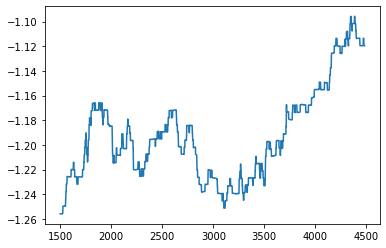

In [158]:
# Plot cumulative reward
with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
    firstline = fh.readline()
    assert firstline[0] == '#'
    df = pd.read_csv(fh, index_col=None)['r']
df.rolling(window=train_steps//10).mean().plot()
plt.show()

In [ ]:
# Train agent
start = time.time()
train_steps = 20000
model.learn(total_timesteps=train_steps)
print (train_steps,"steps took",time.time()-start,"seconds.")

In [166]:
#model.save('./trained_depth4_50000')
trained_model = PPO1.load('/content/trained_depth4_30000.zip')

Finally, we specify the trained agent in the format required for the competition.

In [167]:
def my_agent(obs, config):
    
    #Import saved model trained on best heuristic agent
    from stable_baselines import PPO1
    trained_model = PPO1.load('../input/ppo1-model-for-connectx')
    
    # Use the trained model to select a column
    col, _ = trained_model.predict(np.array(obs['board']).reshape(6,7,1))
    
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [22]:
#TO DO fix:

#with open('submission.py', 'w') as f:
#    f.write(my_agent)

In [168]:
#from submission import my_agent
def mean_reward(rewards):
    epsilon = 0.000001
    return sum(r[0] for r in rewards) / sum(r[0] + r[1] + epsilon for r in rewards)

# Run multiple episodes to estimate agent's performance.
print("TODO: fix")#"My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=1)))
print("TODO: fix")#"My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=1)))

TODO: fix
TODO: fix


In [169]:
def get_win_percentages(agent1, agent2, n_rounds=1):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

And, we calculate how it performs on average, against other agents.

In [171]:
start_time = time.time()
n_rounds=3
get_win_percentages(agent1="random", agent2=pruner,n_rounds=n_rounds)
print ("Total time taken: {} seconds".format(time.time() - start_time))
print ("Time taken per round: {} seconds".format((time.time() - start_time)//n_rounds))

Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 1.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
Total time taken: 28.905571699142456 seconds
Time taken per round: 9.0 seconds
